In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from misc.utils import  *
from misc.estimation import  *

In [2]:
from scipy import optimize

# Functions

In [3]:
# def projection_error(m_i, M_i, P):
#     """
#     code for projection error - does not consider distortion coefficients
#     NOT BEING USED
#     """
#     error_j = []
#     for m,M in zip(m_i, M_i):    
#         m = np.hstack((m,1)) # make image points as homogenous coordinates
#         M = np.hstack((M,0,1)) # make world points as  homogenous coordinates
#         m_ = P.dot(M) # obtain projected point from world points 
#         m_ = m_/m_[-1] 
#         e = np.linalg.norm(m - m_, ord=2) # compute L2 norm
#         error_j.append(e)

#     return np.mean(error_j) 

In [4]:
### Non linear Geometric Error functions

def loss(params, M_pts, m_pts, Extrinsics):
    #     l2error works faster when you have 13 (no. of images) residuals.
    kC = (params[-2], params[-1])
    K = K_matrix(params)
    error = []
    for i,RT in enumerate(Extrinsics):    
        # estimate error for all points in given image
#         e,_ = minGeoError_(m_pts[i], M_pts[i],K, RT, kC)
        e = geometricError(m_pts[i], M_pts[i], K, RT, kC, iscv2 = False)
        error = np.hstack((error,e))
#     print(len(error))
    return error


# def minGeoError_(m_i, M_i, K, RT, kC):
#     """
#     Compute Geometric Error. -From with cv2. projectpoints - runs faster
    
#     """
#     kC = (kC[0],kC[1], 0, 0)
    
#     R,t = splitRT(RT)
#     ones = np.ones(len(m_i)).reshape(-1,1)
#     zeros=  np.zeros(len(m_i)).reshape(-1,1)
    
#     # make image and world points as homogenous coordinates
#     m_i, M_i = np.column_stack((m_i,ones)), np.column_stack((M_i,ones)) 
#     ## reprojected points
#     m_i_,_ = cv2.projectPoints(M_i, R, t, K, kC)

#     error1 = []
#     error2 = []
#     for m, m_ in  zip(m_i[:,:2], m_i_.squeeze()):
#         e_ = np.linalg.norm(m - m_, ord=2) # compute L2 norm        
#         error2.append(e_)
    
#         e_tmp = np.array([m_[0]- m[0] , m_[1]- m[1]])
#         error1.append(e_tmp)
    
#     return np.mean(error2), np.mean(error1)


# def minGeoError(m_i, M_i, K, RT, kC):
    
#     """
#     Compute Geometric Error. -From scratch
#     works but slow, so NOT BEING USED
    
#     """
# #     Finding Geometric error in K
#     u0,v0 = K[0,2], K[1,2]
#     k1,k2 = kC    

#     error2 = []
#     error1 = []

#     for m,M in zip(m_i, M_i):    

# #         m,  np.float64(np.hstack((m,1))),
#         M = np.float64(np.hstack((M,0,1))) # make image and world points as homogenous coordinates        
#         # obtain projected point from world points at extrinsic level
#         m_ = RT.dot(M) 
#         m_ = m_/m_[-1]
#        # obtain projected point from extrinsic level image points to in trinsic level        
#         U = K.dot(m_)
#         U = U/U[-1]
        
#         u,v = U[0], U[1]
#         x, y = m_[0], m_[1]
#         x2y2 = x**2 + y**2
#         u_ = u + (u - u0)*(k1*x2y2 + k2*(x2y2**2))
#         v_ = v + (v - v0)*(k1*x2y2 + k2*(x2y2**2))
        
#         m_ = np.hstack((u_,v_))
#         e_ = np.linalg.norm(m - m_, ord=2) # compute L2 norm        
#         error2.append(e_)
# #         error2 = np.hstack((l2_e,e_))
        
#         e_tmp = np.array([u_- m[0] , v_- m[1]])
#         error1 = np.hstack((e,e_tmp )) # use this error for optimization function
        
#     return np.mean(error2), np.mean(error1)


def geometricError(m_i, M_i, K, RT, kC, iscv2 = False):
    
    """
    This is just the same as projection error tbh
    
    Compute Geometric Error. -From scratch
    works but slow, so NOT BEING USED
    
    """
    
    R,t = splitRT(RT)
    ones = np.ones(len(m_i)).reshape(-1,1)
    zeros=  np.zeros(len(m_i)).reshape(-1,1)

    if iscv2 == False:
        m_i_ = projectPoints(M_i, RT, K, kC)
    else:
        kC = (kC[0],kC[1], 0, 0)
        # make image and world points as homogenous coordinates
        M_i = np.column_stack((M_i,ones)) 
        ## reprojected points
        m_i_,_ = cv2.projectPoints(M_i, R, t, K, kC)

    error = [] 
    for m, m_ in  zip(m_i, m_i_.squeeze()):
        e_ = np.linalg.norm(m - m_, ord=2) # compute L2 norm
        error.append(e_)
                        
    return np.sum(error)


# Code

In [5]:
### Reprojection Error functions

def estimateReprojectionError(K,kC, data, iscv2 = False):
    M_pts, m_pts, Extrinsics = data
    errors = []
    for i,RT in enumerate(Extrinsics):
        # estimate reprojection error for all points in given image
#         e = reProjectionError(M_pts[i], m_pts[i], K, RT, kC)
        e = reProjectionError(M_pts[i], m_pts[i], K, RT, kC, iscv2 = iscv2)
        errors.append(e) 
    return np.mean(errors)

def reProjectionError(M_i, m_i, K, RT, kC, iscv2 = False):
    
    """
    Compute reprojection Error.- From scratch
    works but slow, so NOT BEING USED
    
    """
    R,t = splitRT(RT)
    ones = np.ones(len(m_i)).reshape(-1,1)
    zeros=  np.zeros(len(m_i)).reshape(-1,1)

    if iscv2 == False:
        m_i_ = projectPoints(M_i, RT, K, kC)
    else:
        kC = (kC[0],kC[1], 0, 0)
        # make image and world points as homogenous coordinates
        M_i = np.column_stack((M_i,ones)) 
        ## reprojected points
        m_i_,_ = cv2.projectPoints(M_i, R, t, K, kC)

    error = []            
    for m, m_ in  zip(m_i, m_i_.squeeze()):
        e_ = np.linalg.norm(m - m_, ord=2) # compute L2 norm
        error.append(e_)
        
    return np.mean(error)

def projectPoints(M_i, RT, K, kC):
    u0,v0 = K[0,2], K[1,2]
    k1,k2 = kC    
    m_i_ = []
    for M in M_i:
        M = np.float64(np.hstack((M,0,1))) # make image and world points as homogenous coordinates        
        # project point from world points at extrinsic level - only apply RT
        xy_ = RT.dot(M) 
        xy_ = xy_/xy_[-1]
       # project point from extrinsic level image points to intrinsic level        
        U = K.dot(xy_)
        U = U/U[-1]

        u,v = U[0], U[1]
        x, y = xy_[0], xy_[1]

        r = x**2 + y**2
        u_ = u + (u - u0)*(k1* r + k2*(r**2))
        v_ = v + (v - v0)*(k1* r + k2*(r**2))

        # obtain projected point after applying distortion kC
        m_ = np.hstack((u_,v_))
        m_i_.append(m_)
    return np.array(m_i_)



# def reProjectionError(M_i, m_i, K, RT, kC):
#     """
#     projection error- using cv2
    
#     """
#     kC = (kC[0],kC[1], 0, 0)
#     R,t = splitRT(RT)
#     ones = np.ones(len(m_i)).reshape(-1,1)
#     zeros=  np.zeros(len(m_i)).reshape(-1,1)
    
#     # make image and world points as homogenous coordinates
#     M_i = np.column_stack((M_i,ones)) 
#     ## reprojected points
#     m_i_,_ = cv2.projectPoints(M_i, R, t, K, kC)

#     error = []
#     for m, m_ in  zip(m_i, m_i_.squeeze()):
#         e_ = np.linalg.norm(m - m_, ord=2) # compute L2 norm
#         error.append(e_)
#     return np.mean(error)


In [6]:
# im_paths = sorted(glob.glob('/home/gokul/CMSC733//ReferenceCode/AutoCalib/Calibration_Imgs/*.jpg'))

dataPath = './Calibration_Imgs/'
Savepath = './Outputs/'


f = open(Savepath+"results.txt", "w")
im_paths = sorted(glob.glob(dataPath+'*.jpg'))
M_pts, m_pts, H_matrices = [], [], [] # obj points and image points respectively.
for im_path in im_paths:
    M, m, H = getCorrespondences(im_path)
    M_pts.append(M)
    m_pts.append(m)    
    H_matrices.append(H)

# Estimate K matrix - initial guess
K_init = IntrinsicParameters(H_matrices)
f.write('Initially estimated K matrix : \n '+ str(K_init)+ '\n\n')

# Estimate Extrinsic parameters for every image
Extrinsics_old = []
for i, H in enumerate(H_matrices):
    RT = ExtrinsicParameters(K_init,H)
    Extrinsics_old.append(RT)    
    
kC = (0,0)
print('Distortion Coordinates before optimization:', kC)
f.write('Distortion Coordinates before optimization: '+ str(kC)+ '\n')
reprojection_error =estimateReprojectionError(K_init, kC, (M_pts, m_pts, Extrinsics_old),  False)
reprojection_error2 =estimateReprojectionError(K_init, kC, (M_pts, m_pts, Extrinsics_old), True)

print("Projection error before optimization, : " + str(reprojection_error2) + '(in-built)')
print("Projection error before optimization, : " + str(reprojection_error))

f.write('Projection error before optimization : '+ str(reprojection_error)+ '\n\n\n')

print('Begin Optimization..... This takes a while')

Distortion Coordinates before optimization: (0, 0)
Projection error before optimization, : 0.7201489584193828(in-built)
Projection error before optimization, : 0.6982392631717353
Begin Optimization..... This takes a while


In [7]:
alpha, beta, gamma = K_init[0, 0], K_init[1, 1], K_init[0, 1]
u0,v0 = K_init[0, 2], K_init[1, 2]
k1,k2 = 0, 0

init_params = [alpha, beta, gamma, u0, v0, k1, k2]
out = optimize.least_squares(fun = loss, x0 = init_params, method="lm", args = [M_pts, m_pts, Extrinsics_old])
optimal_params = out.x

kC = (optimal_params[-2], optimal_params[-1])
K = K_matrix(optimal_params)
f.write('optimized K matrix : \n '+ str(K_init)+ '\n\n')

# Re estimate Extrinsic parameters for every image
Extrinsics_new = []
m_pts_ = []
for i, H in enumerate(H_matrices):
    RT = ExtrinsicParameters(K,H)
    Extrinsics_new.append(RT)
    
    M_i = np.column_stack((M_pts[i], np.ones(len(M_pts[i]))))
    R,t = splitRT(RT)
    m_i_, _ = cv2.projectPoints(M_i, R, t, K, (kC[0],kC[1], 0, 0))
    m_pts_.append(m_i_.squeeze())
    
reprojection_error = estimateReprojectionError(K, kC, (M_pts, m_pts, Extrinsics_new),  False)
reprojection_error2 = estimateReprojectionError(K, kC, (M_pts, m_pts, Extrinsics_new), True)
print("Projection error after optimization, : ", reprojection_error2, '(in-built)')
print("Projection error after optimization, : ", reprojection_error)

f.write('Projection error after optimization : '+ str(reprojection_error)+ '\n\n\n')


Rectify( im_paths, np.array(m_pts), np.array(m_pts_), Savepath ,visualize = True)

print('Done calibration')

f.write('##################################################################')
f.close()


Projection error after optimization, :  0.7063718712513029 (in-built)
Projection error after optimization, :  0.6813581331685074
Done calibration


# Work with estimated k and kC

### Computed absolute error of all points

In [9]:
# m_pts_ = []
# for i, RT in enumerate(Extrinsics_new):
#     kC = (kC[0],kC[1], 0, 0)
#     M_i = np.column_stack((M_pts[i], np.ones(len(M_pts[i]))))
#     R,t = splitRT(RT)
# #     R,t = np.float32(R), np.float32(t)
#     m_i_, _ = cv2.projectPoints(M_i, R, t, K, kC)
#     m_pts_.append(m_i_.squeeze())
    
print(np.mean(abs(np.array(m_pts_) - np.array(m_pts))))

0.45191570247025625


In [10]:
m_pts_old = []
for i, RT in enumerate(Extrinsics_old):
    M_i = np.column_stack((M_pts[i], np.ones(len(M_pts[i]))))
    R,t = splitRT(RT)
#     R,t = np.float32(R), np.float32(t)
    m_i_, _ = cv2.projectPoints(M_i, R, t, K_init, (0,0, 0, 0))
    m_pts_old.append(m_i_.squeeze())
    
print(np.mean(abs(np.array(m_pts_old) - np.array(m_pts))))


0.4594494116947101


In [119]:


#         rectifiedImages.append(warpedIm)
#     return rectifiedImages


In [22]:
def Rectify(im_paths, m_pts, m_pts_, Savepath):
    rectifiedImages = []
    for i, (m_i, m_i_, im_path) in enumerate(zip(m_pts,m_pts_,im_paths)):
        im = cv2.imread(im_path)
        height, width = im.shape[:2] 

        H, _ = cv2.findHomography(m_i, m_i_)
        warpedIm = cv2.warpPerspective(im,H,(width,height))
        
#         if(not (os.path.isdir(Savepath))):
#             print(Savepath, "  was not present, creating the folder...")
#             os.makedirs(Savepath)
            
#         cv2.imwrite(Savepath+'rec_im_'+str(i)+'.jpg' , warpedIm)        
        if(not (os.path.isdir(Savepath+'rectified/'))):
            print(Savepath, "  was not present, creating the folder...")
            os.makedirs(Savepath+'rectified/')

        for m, m_ in zip(np.int32(m_i), np.int32(m_i_)):
            cv2.circle(im,tuple(m),15,(0,255,0),-1)
            cv2.circle(warpedIm,tuple(m_),15,(255,0,0),-1)
            
        cv2.imwrite(Savepath+'im_'+str(i)+'.jpg' , im)
        cv2.imwrite(Savepath+'rectified/'+'recIm_'+str(i)+'.jpg' , warpedIm)

In [23]:
Rectify( im_paths, np.array(m_pts), np.array(m_pts_), Savepath )

# plt.figure(figsize = (10,10))
# plt.imshow(outputs[10])

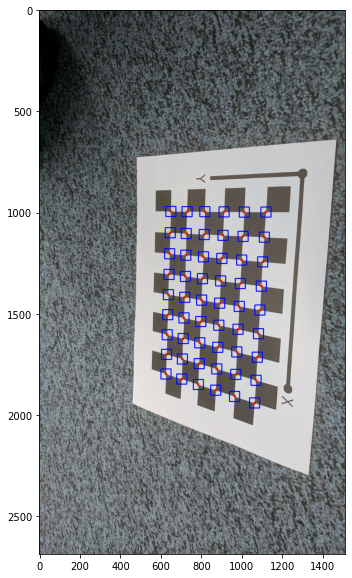

In [75]:
plt.figure(figsize = (10,10))
plt.imshow(outputs[10])

In [70]:
kC

(0, 0, 0, 0)

# References: 

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(X_pts, 
                                                    x_pts, 
                                                    gray(im).shape[::-1], 
                                                    None, 
                                                    None)

599 1605 [0. 0.]
589 1513 [1. 0.]
579 1421 [2. 0.]
571 1331 [3. 0.]
562 1241 [4. 0.]
553 1152 [5. 0.]
544 1063 [6. 0.]
535 975 [7. 0.]
526 887 [8. 0.]
658 1599 [0. 1.]


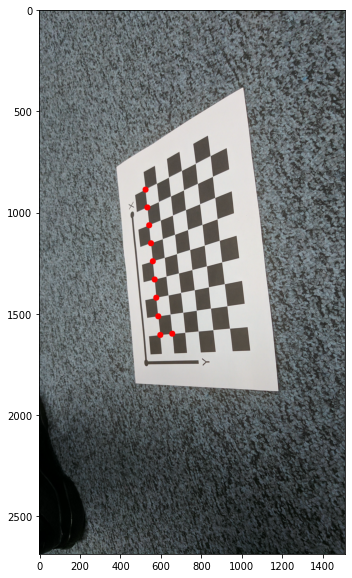

In [61]:
## to check corner orders
im = 
im_print = im.copy()
for i, corner in enumerate(corners[:10]):
    a,b = np.int32(corner)
    print(a,b,X[i] )
    cv2.circle(im_print,(a,b),15,(255,0,0),-1)
    
plt.figure(figsize = (10,10))   
plt.imshow(im_print)